In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import analysis, plot, model, collection
import jax  # Autodiff, easy batching of functions
import jax.numpy as jnp  # Like numpy but written to run fast on GPU
import numpy as np
import distrax  # Tensorflow probability for Jax
import haiku as hk  # Used for making neural nets
import tqdm  # Used for reporting training progress
import chex  # Used for checking dimensions, useful for debugging
from jax.scipy.linalg import cholesky  # Need to structure covariance appropriately for learning
from matplotlib import pyplot as plt
from functools import partial
import optax  # Used for optimization using SGD, Adam etc
from matplotlib import pyplot as plt
import matplotlib
from pathlib import Path
import pickle

# plt.style.use('seaborn-v0_8-deep')
# Global flag to set a specific platform, must be used at startup.
# jax.config.update('jax_platform_name', 'cpu')

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
ACTION_DIM = 64
STATE_DIM = 2
batch_size = 500

In [4]:
@jax.jit
def mixture_policy_log_prob(params, actions, prior_params):
  chex.assert_shape(actions, (None,ACTION_DIM))
  dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=prior_params["probs"]),
        # components_distribution = distrax.MultivariateNormalFullCovariance(loc=prior_params["locs"],covariance_matrix=prior_params["covs"]))
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["locs"],scale_tri=prior_params["scales"]))

  dist_model = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=params["probs"]),
        # components_distribution = distrax.MultivariateNormalFullCovariance(loc=params["locs"],covariance_matrix=params["covs"]))
        components_distribution = distrax.MultivariateNormalTri(loc=params["locs"],scale_tri=params["scales"]))

  log_probs_prior = dist_prior.log_prob(actions)
  log_probs_model = dist_model.log_prob(actions)
  chex.assert_shape(log_probs_prior, (actions.shape[0],))
  chex.assert_shape(log_probs_model, (actions.shape[0],))

  return log_probs_model # + log_probs_prior

@partial(jax.jit, static_argnums=(2,))
def policy_sample(rng, params, num_samples):
  """See policy log prob."""
  samples = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=params["probs"]),
        # components_distribution = distrax.MultivariateNormalFullCovariance(loc=params["locs"],covariance_matrix=params["covs"]))
        components_distribution = distrax.MultivariateNormalTri(loc=params["locs"],scale_tri=params["scales"])).sample(seed=rng, sample_shape=(num_samples,))
  chex.assert_shape(samples, (num_samples, ACTION_DIM))

  return samples

@partial(jax.jit, static_argnums=(3,))
def kl_divergence(rng_key, params, prior_params, n_samples=500):
    # Measures the information gain achieved if target probability distribution would be used instead of predicted probability distribution.
    dist_prior = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=prior_params["probs"]),
        # components_distribution = distrax.MultivariateNormalFullCovariance(loc=prior_params["locs"],covariance_matrix=prior_params["covs"]))
        components_distribution = distrax.MultivariateNormalTri(loc=prior_params["locs"],scale_tri=prior_params["scales"]))

    dist_policy = distrax.MixtureSameFamily(
        mixture_distribution = distrax.Categorical(probs=params["probs"]),
        # components_distribution = distrax.MultivariateNormalFullCovariance(loc=params["locs"],covariance_matrix=params["covs"]))
        components_distribution = distrax.MultivariateNormalTri(loc=params["locs"],scale_tri=params["scales"]))
    
    # # # This is one way!
    # # # sample from the prior, this is what we're taking the expectation under!
    # prior_samples = dist_prior.sample(seed=rng_key, sample_shape=(n_samples,))
    # # # get log probs under the prior and policy  
    # prior_x = dist_prior.log_prob(prior_samples)
    # policy_x = dist_policy.log_prob(prior_samples)
    # return jnp.mean(prior_x - policy_x)

    # This is the other way
    # sample from the policy, this is what we're taking the expectation under!
    policy_samples = dist_policy.sample(seed=rng_key, sample_shape=(n_samples,))
    # get log probs under the prior and policy  
    prior_x = dist_prior.log_prob(policy_samples)
    policy_x = dist_policy.log_prob(policy_samples)
    return jnp.mean(policy_x - prior_x)

def loss_fn(params, actions, rewards, prior_params, alpha, rng_key):
  chex.assert_shape(actions, (batch_size,ACTION_DIM))
  chex.assert_shape(rewards, (batch_size,))
  # log_probs = normal_policy_log_prob(params, actions, prior_params)
  log_probs = mixture_policy_log_prob(params, actions, prior_params)
  divergence = kl_divergence(rng_key, params, prior_params) 
  chex.assert_shape(log_probs, (batch_size,))
  rewards = jax.lax.stop_gradient(rewards)  # Don't backprop through the reward function
  # larger -log_prob = smaller probability 
  # larger divergence = further from prior?
  kl = alpha*divergence
  loss = -(rewards * log_probs).sum() + kl
  return loss, kl

@jax.jit
def get_rewards(a, target, decoder):
  # sample from target distribution, then find distances
  # model = distrax.MultivariateNormalTri(loc=model_params_['loc'], scale_tri=model_params_['scale'])
  # target_samples = target_dist.sample(seed=key, sample_shape=(a.shape[0],))
  # return -jnp.sum(jnp.subtract(a, target_samples)**2,axis=1)

  # subtract from target distribution mean
  # e^-root(2) --> 1
  # 0.24 --> 1
  return -jnp.sum(jnp.subtract(a @ decoder.T, target)**2,axis=1)

@jax.jit  # This compiles the function to the GPU
def update_fn(params, actions, rewards, opt_state, prior_params, rng_key, alpha, wlr=1e-4, epsilon=1e-8):
  optimizer = optax.adam(wlr)
  loss, kl = loss_fn(params, actions, rewards, prior_params, alpha, rng_key)
  grads, kl = jax.grad(loss_fn, has_aux=True)(params, actions, rewards, prior_params, alpha, rng_key)
  # scale = params["scale"]
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  # params["scale"] = scale
  # params['scale'] = jnp.clip(params['scale'], a_min=epsilon)  # Clip for numerical stability
  return params, opt_state, loss, kl

In [5]:
def plot_samples(dist,num_samples,label,rng, decoder=None, ax=None, **kwargs):
  if ax is None:
    # split for new samples
    samples = dist.sample(seed=rng, sample_shape=(num_samples,)).T
    if decoder is None:
      plt.scatter(samples[0],samples[1],label=label)
    else:
      samples = decoder @ samples
      plt.scatter(samples[0],samples[1],label=label)
  else:
    # split for new samples
    samples = dist.sample(seed=rng, sample_shape=(num_samples,)).T
    if decoder is None:
      ax.scatter(samples[0],samples[1],label=label,**kwargs)
    else:
      samples = decoder @ samples
      ax.scatter(samples[0],samples[1],label=label,**kwargs)
     

def make_prior_dist(prior_params):
   return distrax.MixtureSameFamily(
    mixture_distribution = distrax.Categorical(probs=prior_params["probs"]),
    # components_distribution = distrax.MultivariateNormalFullCovariance(loc=prior_params["locs"],covariance_matrix=prior_params["covs"]))
    components_distribution = distrax.MultivariateNormalTri(loc=prior_params["locs"],scale_tri=prior_params["scales"]))

def make_starting_dist(starting_params):
    return distrax.MixtureSameFamily(
    mixture_distribution = distrax.Categorical(probs=starting_params["probs"]),
    # components_distribution = distrax.MultivariateNormalFullCovariance(loc=starting_params["locs"],covariance_matrix=starting_params["covs"]))
    components_distribution = distrax.MultivariateNormalTri(loc=starting_params["locs"],scale_tri=starting_params["scales"]))
   
def scale_to_cov(sq_mat):
    return jnp.dot(sq_mat.T, sq_mat)   

## set up params

In [6]:
def generate_subject_prior(subject_idx):
    mixture_model = model.log_model(model.load_log_movement_models(subject_idx)[0])
    prior_weights = jnp.array(mixture_model.weights)
    prior_means = jnp.array(mixture_model.means)
    for C in mixture_model.covariances:
        C[56,56] = 1e-5
    prior_covs = jnp.array(mixture_model.covariances)
    prior_scales = jnp.linalg.cholesky(prior_covs)
    return {
        "probs" : prior_weights,
        "locs" : prior_means,
        "scales" : prior_scales
        # "covs" : jnp.log(prior_covs)
    }

def generate_starting_policy_params(subject_idx, n_components=1, sigma=0.1, prior_match=False):
    if prior_match:
        # mixture_model = model.log_model(model.load_log_movement_models(subject_idx)[0])
        # prior_weights = jnp.array(mixture_model.weights)
        # top_weight_idxs = jnp.argsort(prior_weights)[::-1][:3]
        # prior_means = jnp.array(mixture_model.means[top_weight_idxs])
        # n_components = prior_means.shape[0]
        # for C in mixture_model.covariances:
        #     C[56,56] = 1e-5
        # prior_covs = jnp.array(mixture_model.covariances[top_weight_idxs])
        # prior_scales = jnp.linalg.cholesky(prior_covs)
        # return {
        #     "probs" : jnp.array([1/n_components for _ in range(n_components)]),
        #     "locs" : prior_means,
        #     "scales" : prior_scales
        #     # "covs" : jnp.log(prior_covs)
        # }
        stack = analysis.load_trial_stack(subject_idx)[:9].transpose(0,1,3,2).reshape(-1,64)
        stack = analysis.remove_nan_rows(stack)
        C = np.cov(stack.T)
        C[56,56] = 1e-4
        return {
            "probs" : jnp.array([1/n_components for _ in range(n_components)]),
            "locs" : jnp.array([jnp.zeros(shape=(64,))]),
            "scales" : jnp.linalg.cholesky(jnp.array([C]))
            # "covs" : jnp.log(prior_covs)
        }
    else:
        starting_means = jnp.array([np.ones(shape=(64))*i for i in range(n_components)]).reshape(-1,64)
        starting_covs = jnp.array([np.ones(shape=(ACTION_DIM,ACTION_DIM))*sigma*0.001 + np.eye(ACTION_DIM)*sigma for _ in range(n_components)])
        starting_scales = jnp.linalg.cholesky(starting_covs)
        return {
            'probs': jnp.array([1/n_components for i in range(n_components)]),
            'locs': starting_means,
            'scales': starting_scales
            # 'covs': jnp.log(starting_covs)
        }

## pre-compute prior params

(500, 64)
(2, 500)


(-2.0, 2.0)

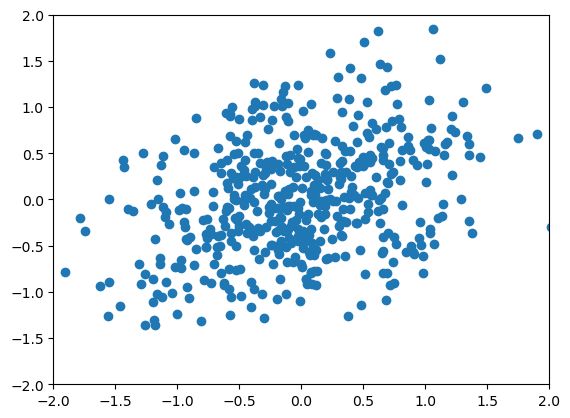

In [7]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
p = generate_starting_policy_params(2,prior_match=True)
d = make_prior_dist(p)
decoder = subjects[1].decoder[-2:,:]
samples = d.sample(seed=subkey,sample_shape=500)
print(samples.shape)
trajectory = decoder @ samples.T
print(trajectory.shape)
# plt.plot(samples[:,5],samples[:,54],"o")
plt.plot(trajectory[0],trajectory[1],"o")
plt.ylim([-2,2])
plt.xlim([-2,2])

### test subject prior

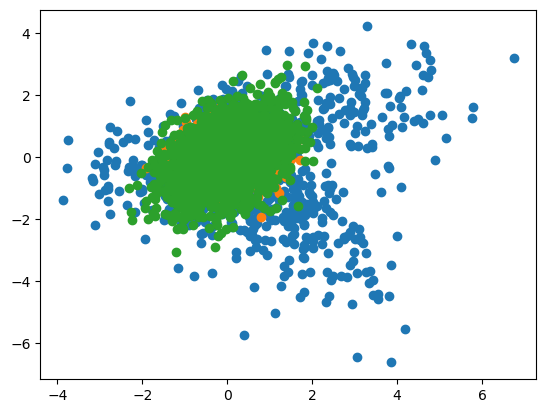

In [8]:
subject_idx = 1
prior_params = generate_subject_prior(subject_idx)
starting_params = generate_starting_policy_params(subject_idx,prior_match=False)
starting_params_match = generate_starting_policy_params(subject_idx,prior_match=True)
decoder = subjects[subject_idx].decoder[-2:,:]

plt.figure()
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
samples = policy_sample(subkey, prior_params, 2000)
s = samples @ decoder.T
plt.plot(s[:,0],s[:,1],"o")

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
samples = policy_sample(subkey, starting_params, 2000)
s = samples @ decoder.T
plt.plot(s[:,0],s[:,1],"o")

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
samples = policy_sample(subkey, starting_params_match, 2000)
s = samples @ decoder.T
plt.plot(s[:,0],s[:,1],"o")

### test KL

In [9]:
SIGMA = 0.1
n_components = 3

test_means = jnp.array([np.ones(shape=(64))*5 for i in range(n_components)]).reshape(-1,64)
test_covs = jnp.array([np.ones(shape=(ACTION_DIM,ACTION_DIM))*0.001 + np.eye(ACTION_DIM)*SIGMA for _ in range(n_components)])
prior_scales = jnp.linalg.cholesky(test_covs)
test_params = {
    "probs" : jnp.array([1/n_components for _ in range(n_components)]),
    "locs" : test_means,
    "scales" : prior_scales
    # "covs" : test_covs
}

test_means2 = jnp.array([np.ones(shape=(64))*-2 for i in range(n_components)]).reshape(-1,64)
test_covs2 = jnp.array([np.ones(shape=(ACTION_DIM,ACTION_DIM))*0.001 + np.eye(ACTION_DIM)*SIGMA for _ in range(n_components)])
test_scales2 = jnp.linalg.cholesky(test_covs2)
test_params2 = {
    'probs': jnp.array([1/n_components for _ in range(n_components)]),
    'locs': test_means2,
    'scales': test_scales2
    # 'covs': test_covs2
}

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
print(kl_divergence(subkey, test_params2, test_params, n_samples=500))

prior_dist = make_prior_dist(test_params)
target_dist = make_starting_dist(test_params2)
print(prior_dist.components_distribution[0].kl_divergence(target_dist.components_distribution[0]),target_dist.components_distribution[0].kl_divergence(prior_dist.components_distribution[0]))

9559.852
9560.977 9560.977


Reward \in [0,1]
Log Probs \in [-inf, ~0] -- some big negative number



# train

In [18]:
num_iter = 10000

learning_rate = 1e-4
n_components = 1
subject_idxs = list(range(1))
kl_alphas = [0.0,0.1,0.5,1.0,3.0,5.0,10.0]
prior_matches = [True, False]
targets = range(1)

In [11]:
for subject_idx in subject_idxs[:1]:
  for target_idx in targets:
    target = collection.compute_target_vec_from_number(target_number=target_idx+1)
    target = jnp.array(target).reshape(1,-1)
    for prior_match in prior_matches:
      for kl_alpha in kl_alphas:
        folderpath = Path("rl_models")
        if not folderpath.exists():
            Path.mkdir(folderpath)
        if prior_match:
          file_prefix = f"subject_{subject_idx}_target_{target_idx}_alpha_{kl_alpha}_prior_match"
        else:
          file_prefix = f"subject_{subject_idx}_target_{target_idx}_alpha_{kl_alpha}_gaussian"

        filepath = Path(folderpath / (file_prefix + ".pkl"))
        # if filepath.exists():
        #   print(f"File {filepath} exists.")
          
        # else:        
        print(f"subject: {subject_idx} - target: {target_idx} - alpha: {kl_alpha} - prior: {prior_match}")
        prior_params = generate_subject_prior(subject_idx)
        params = generate_starting_policy_params(subject_idx,prior_match=prior_match)

        opt_state = optax.adam(learning_rate).init(params)
        losses = np.zeros(num_iter)
        rewards = np.zeros(num_iter)
        divergences = np.zeros(num_iter)
        params_list = []

        # the starting key
        key = jax.random.PRNGKey(2)
        key, subkey = jax.random.split(key)

        decoder = jnp.array(subjects[subject_idx].decoder[-2:,:])

        params_list.append(params)
        for t in tqdm.tqdm(range(num_iter)):
          # split key for policy sample
          key, subkey = jax.random.split(key)
          actions_t = policy_sample(params=params, num_samples=batch_size, rng=subkey)
          rewards_t = get_rewards(actions_t, target, decoder)
          rewards[t] = rewards_t.mean()
          # split key for KL penalty
          key, subkey = jax.random.split(key)
          params, opt_state, loss_t, divergence_t = update_fn(params, actions_t, rewards_t, opt_state, prior_params, subkey, alpha=kl_alpha, wlr=learning_rate)
          losses[t] = loss_t
          divergences[t] = divergence_t
          params_list.append(params)

        print(f"Saving {filepath}.")
        with open(filepath,"wb") as handle:
            pickle.dump(params_list, handle)

subject: 0 - target: 0 - alpha: 0.1 - prior: True


100%|██████████| 10000/10000 [03:13<00:00, 51.70it/s]


Saving rl_models/subject_0_target_0_alpha_0.1_prior_match.pkl.
subject: 0 - target: 0 - alpha: 0.1 - prior: False


  6%|▌         | 563/10000 [00:11<03:08, 50.02it/s]


KeyboardInterrupt: 

# plot 

In [19]:
def params_to_means(params):
    return np.array([[m for m in p["locs"]] for p in params])

def params_to_covs(params):
    return np.array([[C @ C.T for C in p["scales"]] for p in params])

def decode_covs(covs,decoder):
    cs = []
    for cov in covs:
        cs += [decode_cov(cov)]
    return np.array(cs,decoder)

def decode_cov(C, decoder):
    return decoder @ C @ decoder.T

def decode_means(means,decoder):
    ms = []
    for mt in means:
        mts = []
        for m in mt:
            mts += [decode_mean(m,decoder)]
        ms += [mts]
    return np.array(ms)

def decode_mean(m, decoder):
    return decoder @ m

def params_to_probs(params):
    return np.array([[m for m in p["probs"]] for p in params])

def load_params(subject_idx, kl_alpha, target_idx, prior_match):
    folderpath = Path("rl_models")
    if prior_match:
        file_prefix = f"subject_{subject_idx}_target_{target_idx}_alpha_{kl_alpha}_prior_match"
    else:
        file_prefix = f"subject_{subject_idx}_target_{target_idx}_alpha_{kl_alpha}_gaussian"
    filepath = Path(folderpath / (file_prefix + ".pkl"))
    with open(filepath,"rb") as handle:
        return pickle.load(handle)

In [20]:
colors = ['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:pink','tab:brown']

In [21]:
subjects_to_plot = range(1)
targets_to_plot = range(1)
kl_alphas_to_plot = kl_alphas[0:4]
priors_to_plot = [True,False]

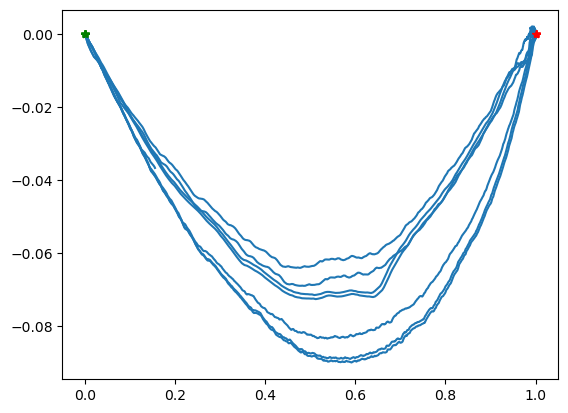

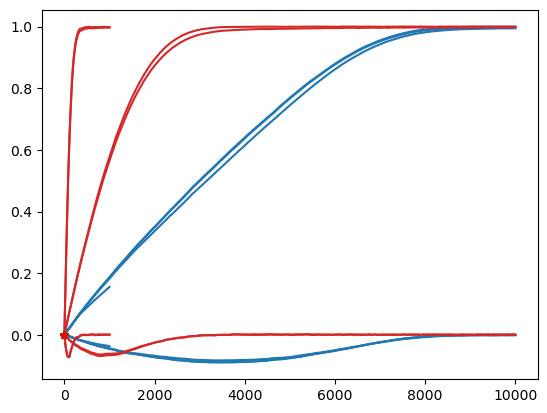

In [22]:
fig, mean_ax = plt.subplots(1,1)
fig, mean_ax2 = plt.subplots(1,1)
# fig, loss_ax = plt.subplots(1,1)
# fig, reward_ax = plt.subplots(1,1)
# fig, KL_ax = plt.subplots(1,1)

for si, subject_idx in enumerate(subjects_to_plot): # enumerate(subject_idxs):
    decoder = subjects[subject_idx].decoder[-2:,:]
    for target_idx in targets_to_plot:
        target = collection.compute_target_vec_from_number(target_idx+1)
        for pi, prior_match in enumerate(priors_to_plot):
            for i, kl_alpha in enumerate(kl_alphas_to_plot):
                params_list = load_params(subject_idx,kl_alpha,target_idx,prior_match)
                # prior_params = generate_subject_prior(subject_idx)
                # probs = params_to_probs(params_list)
                # plt.plot(probs)
                # means
                means = params_to_means(params_list)
                means = decode_means(means,decoder)
                mean_ax.plot(means[:,0,0], means[:,0,1],"-",color=colors[si])
                mean_ax.plot(means[0][0][0],means[0][0][1],"g*")
                mean_ax.plot(target[0],target[1],"r*")
                
                mean_ax2.plot(means[:,0,0],"-",color=colors[pi])
                mean_ax2.plot(means[:,0,1],"-",color=colors[pi])
                mean_ax2.plot(means[0][0][0],means[0][0][1],"g*")
                mean_ax2.plot(target[0],target[1],"r*")

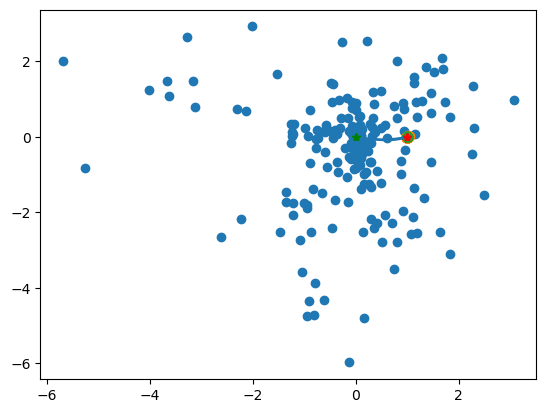

In [43]:
fig, big_ax = plt.subplots(1,1)
plt.plot(target[0],target[1],"r*",label="Target Mean",zorder=100)
key = jax.random.PRNGKey(10)

for si, subject_idx in enumerate(subjects_to_plot):
    decoder = subjects[subject_idx].decoder[-2:,:]
    key, subkey = jax.random.split(key)
    plot_samples(make_prior_dist(prior_params),200,"Mixture Prior",rng=subkey,decoder=decoder,alpha=0.1)
    for target_idx in targets_to_plot:
        target = collection.compute_target_vec_from_number(target_idx+1)
        for prior_match in priors_to_plot:
            for i, kl_alpha in enumerate(kl_alphas_to_plot):
                params_list = load_params(subject_idx,kl_alpha,target_idx,prior_match)
                # loss_ax.plot(losses,"k-")
                # loss_ax.set_title("Loss")

                # reward_ax.plot(rewards,"k-")
                # reward_ax.set_title("Reward")

                # KL_ax.plot(divergences,"k-")
                # KL_ax.set_title("KL")

                # key, subkey = jax.random.split(key)
                # plot_samples(make_starting_dist(params_list[0]),1000,"Starting",rng=subkey,decoder=decoder)

                key, subkey = jax.random.split(key)
                fitted_dist = distrax.MultivariateNormalTri(
                    loc=params_list[-1]['locs'][0],
                    scale_tri=params_list[-1]['scales'][0],
                    )
                plot_samples(fitted_dist,200,"Fit",subkey,decoder=decoder)

                means = params_to_means(params_list)
                means = decode_means(means,decoder)
                big_ax.plot(means[:,0,0], means[:,0,1],"-",color=colors[si])
                big_ax.plot(target[0],target[1],"r*")
                big_ax.plot(means[0][0][0],means[0][0][1],"g*")            

    # big_ax.legend()

/Users/spencer/phd/phd/analysis/notebooks/_modeling/../../analysis/plot.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ellipse = Ellipse((0, 0),


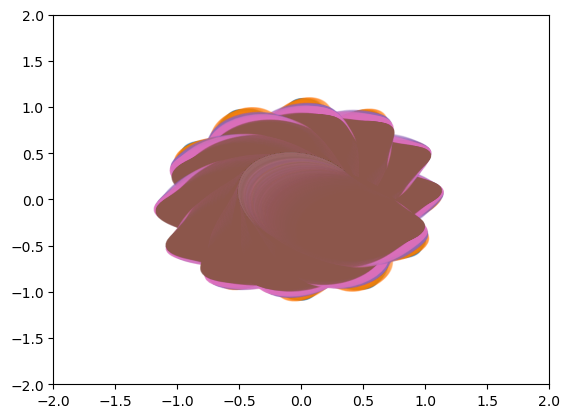

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
for subject_idx in subjects_to_plot:
    decoder = subjects[subject_idx].decoder[-2:,:]
    for target_idx in range(12):
        target = collection.compute_target_vec_from_number(target_idx+1)
        for prior_match in [False]:
            for i, kl_alpha in enumerate(kl_alphas):
                params_list = load_params(subject_idx,kl_alpha,target_idx,prior_match)
                for Cs, ms in list(zip(params_to_covs(params_list), params_to_means(params_list)))[0::10]:
                    for C, m in zip(Cs, ms):
                        plot.plot_confidence_ellipse(decode_mean(m,decoder), decode_cov(C,decoder),ax=ax, n_std=1.0, alpha=0.1, color=colors[i])

In [ ]:
def mean_quadratic_form(C, subspace_basis):
    dim = subspace_basis.shape[0]
    return (np.sum(np.diag(subspace_basis @ C @ subspace_basis.T)) / dim).ravel()

task, null = analysis.compute_subspaces(decoder)
C = params_to_covs(params_list)[-1][0]

In [ ]:
subjects_to_plot = range(30)

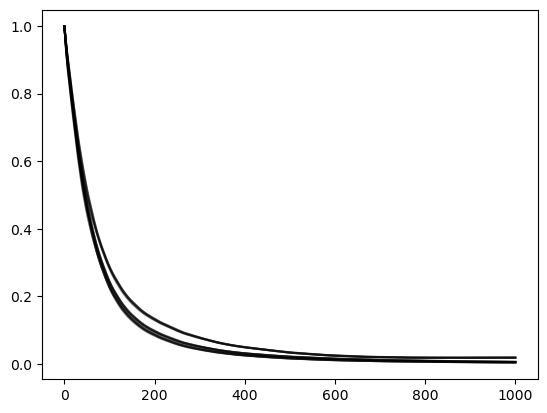

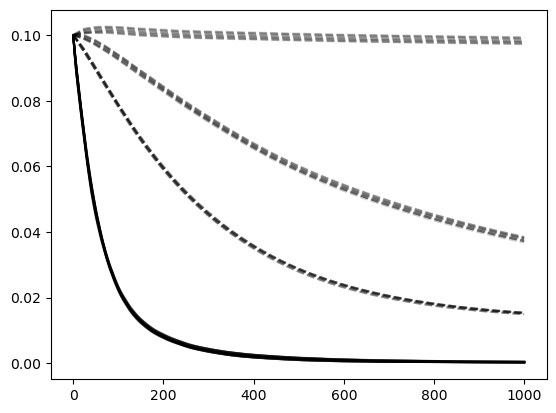

In [16]:
fig, ax1 = plt.subplots(1,1)
fig, ax2 = plt.subplots(1,1)
for si, subject_idx in enumerate(subjects_to_plot):
    decoder = subjects[subject_idx].decoder[-2:,:]
    task, null = analysis.compute_subspaces(decoder)
    for target_idx in range(12):
        for prior_match in [False]:
            for i, kl_alpha in enumerate(kl_alphas[:3]):
                ratios = []
                tasks = []
                nulls = []
                params_list = load_params(subject_idx,kl_alpha,target_idx,prior_match)
                for C in params_to_covs(params_list):
                    task_proj = analysis.mean_quadratic_form(C[0],task)
                    tasks.append(task_proj)
                    null_proj = analysis.mean_quadratic_form(C[0],null)
                    nulls.append(null_proj)
                    ratios.append(task_proj/null_proj)
                ax1.plot(ratios,color="k",alpha=0.2)
                ax2.plot(tasks,color="k",alpha=0.2)
                ax2.plot(nulls,"--",color="k",alpha=0.2)